In [1]:
%matplotlib inline


`Introduction <introyt1_tutorial.html>`_ ||
`Tensors <tensors_deeper_tutorial.html>`_ ||
`Autograd <autogradyt_tutorial.html>`_ ||
`Building Models <modelsyt_tutorial.html>`_ ||
`TensorBoard Support <tensorboardyt_tutorial.html>`_ ||
**Training Models** ||
`Model Understanding <captumyt.html>`_

Training with PyTorch
=====================

Follow along with the video below or on `youtube <https://www.youtube.com/watch?v=jF43_wj_DCQ>`__.

.. raw:: html

   <div style="margin-top:10px; margin-bottom:10px;">
     <iframe width="560" height="315" src="https://www.youtube.com/embed/jF43_wj_DCQ" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
   </div>

Introduction
------------

In past videos, we’ve discussed and demonstrated:

- Building models with the neural network layers and functions of the torch.nn module
- The mechanics of automated gradient computation, which is central to
  gradient-based model training 
- Using TensorBoard to visualize training progress and other activities

In this video, we’ll be adding some new tools to your inventory:

- We’ll get familiar with the dataset and dataloader abstractions, and how
  they ease the process of feeding data to your model during a training loop 
- We’ll discuss specific loss functions and when to use them
- We’ll look at PyTorch optimizers, which implement algorithms to adjust
  model weights based on the outcome of a loss function

Finally, we’ll pull all of these together and see a full PyTorch
training loop in action.


Dataset and DataLoader
----------------------
 
The ``Dataset`` and ``DataLoader`` classes encapsulate the process of
pulling your data from storage and exposing it to your training loop in
batches.

The ``Dataset`` is responsible for accessing and processing single
instances of data.
 
The ``DataLoader`` pulls instances of data from the ``Dataset`` (either
automatically or with a sampler that you define), collects them in
batches, and returns them for consumption by your training loop. The
``DataLoader`` works with all kinds of datasets, regardless of the type
of data they contain.
 
For this tutorial, we’ll be using the Fashion-MNIST dataset provided by
TorchVision. We use ``torchvision.transforms.Normalize()`` to
zero-center and normalize the distribution of the image tile content,
and download both training and validation data splits.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False, num_workers=2)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


As always, let’s visualize the data as a sanity check:




Sneaker  Dress  Pullover  Sandal


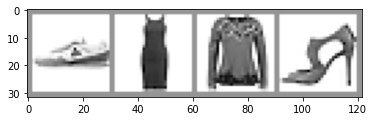

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = dataiter.next()

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

The Model
---------

The model we’ll use in this example is a variant of LeNet-5 - it should
be familiar if you’ve watched the previous videos in this series.




In [4]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

model = GarmentClassifier()

Loss Function
-------------

For this example, we’ll be using a cross-entropy loss. For demonstration
purposes, we’ll create batches of dummy output and label values, run
them through the loss function, and examine the result.




In [5]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])
    
print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.1349, 0.1428, 0.1389, 0.0661, 0.1783, 0.8225, 0.4036, 0.3720, 0.3932,
         0.8740],
        [0.7170, 0.9034, 0.3667, 0.7303, 0.5403, 0.0235, 0.1202, 0.6777, 0.6204,
         0.2658],
        [0.2580, 0.7038, 0.9527, 0.3985, 0.7427, 0.3612, 0.7576, 0.7737, 0.2863,
         0.2614],
        [0.3971, 0.1760, 0.5933, 0.2144, 0.3012, 0.1365, 0.5683, 0.5432, 0.7080,
         0.5091]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.5101590156555176


Optimizer
---------

For this example, we’ll be using simple `stochastic gradient
descent <https://pytorch.org/docs/stable/optim.html>`__ with momentum.

It can be instructive to try some variations on this optimization
scheme:

- Learning rate determines the size of the steps the optimizer
  takes. What does a different learning rate do to the your training
  results, in terms of accuracy and convergence time?
- Momentum nudges the optimizer in the direction of strongest gradient over
  multiple steps. What does changing this value do to your results? 
- Try some different optimization algorithms, such as averaged SGD, Adagrad, or
  Adam. How do your results differ?




In [6]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

The Training Loop
-----------------

Below, we have a function that performs one training epoch. It
enumerates data from the DataLoader, and on each pass of the loop does
the following:

- Gets a batch of training data from the DataLoader
- Zeros the optimizer’s gradients 
- Performs an inference - that is, gets predictions from the model for an input batch
- Calculates the loss for that set of predictions vs. the labels on the dataset
- Calculates the backward gradients over the learning weights
- Tells the optimizer to perform one learning step - that is, adjust the model’s
  learning weights based on the observed gradients for this batch, according to the
  optimization algorithm we chose
- It reports on the loss for every 1000 batches.
- Finally, it reports the average per-batch loss for the last
  1000 batches, for comparison with a validation run




In [7]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        
        # Make predictions for this batch
        outputs = model(inputs)
        
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        # Adjust learning weights
        optimizer.step()
        
        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
            
    return last_loss

Per-Epoch Activity
~~~~~~~~~~~~~~~~~~

There are a couple of things we’ll want to do once per epoch: 

- Perform validation by checking our relative loss on a set of data that was not
  used for training, and report this 
- Save a copy of the model

Here, we’ll do our reporting in TensorBoard. This will require going to
the command line to start TensorBoard, and opening it in another browser
tab.




In [8]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)
    
    # We don't need gradients on to do reporting
    model.train(False)
    
    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss
    
    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    
    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
    
    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 1.7571685534715653
  batch 2000 loss: 0.8312974722627551
  batch 3000 loss: 0.7126634035278112
  batch 4000 loss: 0.6384900091029704
  batch 5000 loss: 0.5999928500729147
  batch 6000 loss: 0.5464812559061684
  batch 7000 loss: 0.5224637653692625
  batch 8000 loss: 0.5196582598038949
  batch 9000 loss: 0.4989593081502244
  batch 10000 loss: 0.45268663816165644
  batch 11000 loss: 0.4568853628158104
  batch 12000 loss: 0.44011706673912704
  batch 13000 loss: 0.4418388886395842
  batch 14000 loss: 0.40392924795579166
  batch 15000 loss: 0.4032055336878984
LOSS train 0.4032055336878984 valid 0.43293729424476624
EPOCH 2:
  batch 1000 loss: 0.41938271237467417
  batch 2000 loss: 0.36157548560819125
  batch 3000 loss: 0.37753455472551284
  batch 4000 loss: 0.36942293857666664
  batch 5000 loss: 0.3792187232526194
  batch 6000 loss: 0.37028102594273515
  batch 7000 loss: 0.36375533778115643
  batch 8000 loss: 0.354110435110284
  batch 9000 loss: 0.3749184813323664


To load a saved version of the model:

::

   saved_model = GarmentClassifier()
   saved_model.load_state_dict(torch.load(PATH))

Once you’ve loaded the model, it’s ready for whatever you need it for -
more training, inference, or analysis.

Note that if your model has constructor parameters that affect model
structure, you’ll need to provide them and configure the model
identically to the state in which it was saved.

Other Resources
---------------

-  Docs on the `data
   utilities <https://pytorch.org/docs/stable/data.html>`__, including
   Dataset and DataLoader, at pytorch.org
-  A `note on the use of pinned
   memory <https://pytorch.org/docs/stable/notes/cuda.html#cuda-memory-pinning>`__
   for GPU training
-  Documentation on the datasets available in
   `TorchVision <https://pytorch.org/vision/stable/datasets.html>`__,
   `TorchText <https://pytorch.org/text/stable/datasets.html>`__, and
   `TorchAudio <https://pytorch.org/audio/stable/datasets.html>`__
-  Documentation on the `loss
   functions <https://pytorch.org/docs/stable/nn.html#loss-functions>`__
   available in PyTorch
-  Documentation on the `torch.optim
   package <https://pytorch.org/docs/stable/optim.html>`__, which
   includes optimizers and related tools, such as learning rate
   scheduling
-  A detailed `tutorial on saving and loading
   models <https://pytorch.org/tutorials/beginner/saving_loading_models.html>`__
-  The `Tutorials section of
   pytorch.org <https://pytorch.org/tutorials/>`__ contains tutorials on
   a broad variety of training tasks, including classification in
   different domains, generative adversarial networks, reinforcement
   learning, and more 


